In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch
import scipy.io as sio
import os
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

In [3]:
device = (
    "cuda"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Using cpu device
Is CUDA supported by this system? True
CUDA version: 11.7
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 1650


In [29]:
# mat_data = sio.loadmat("dib_105174_V1_A.mat")
# # Access the 2x7 matrix from the .mat file
# print(mat_data.keys())

# matrix = mat_data['ssvep']

# # for key, value in mat_data.items() :
# #     print (key, value)

# print(matrix[0].shape[0])

# matrix = np.squeeze(matrix)
# X = np.zeros((matrix.shape[0], matrix[0].shape[0]))
# for i in range(X.shape[0]):
#     X[i] = matrix[i]
# print(X.shape)

In [30]:
# # Loop through each cell in the 2x7 matrix
# for i in range(matrix.shape[0]):
#     for j in range(matrix.shape[1]):
#         # Access the data in the current cell
#         cell_data = matrix[i, j]

#         # Handle a 1D array correctly
#         if cell_data.ndim == 1:
#             plt.plot(cell_data)
#             plt.title("Column 0")
#             plt.show()
#         else:
#             # Plot each column in the cell's data
#             for k in range(cell_data.shape[1]):
#                 plt.plot(cell_data[:, k])
#                 plt.title(f"Column {k}")
#                 plt.show()

In [31]:

# raw_fname = 'D:\Anne\Facultate\licenta' 
# # giving directory name 
# # giving file extension
# ext = ('.mat')
 
# # iterating over all files
# for files in os.listdir(raw_fname):
#     if files.endswith(ext):
#         print(files)  # printing file name of desired extension
#     else:
#         continue

# raw = mne.io.Raw(mat_data)
# print(raw)
# print(raw.info)
# print(raw.ch_names[:5])


In [4]:
with open('/Anne/Facultate/licenta/ScienceDirect_files_16Dec2022_10-38-19/CSV\sig10Hz_V1_A.csv') as f:
    train = pd.read_csv(f)
train = train.drop('ECG', axis=1)
train.head(5120)


,FP1,FP2,PG1,PG2,F7,F3,F2,F4,F8,C3,...,P3,P4,P2,T3,T4,T5,T6,O1,OZ,O2
0,-12,-9,-37,-7,-58,-2,-68,-41,-29,-9,...,-31,-9,11,4,5,5,-23,12,0,-21
1,6,2,-30,5,-36,1,-52,-28,-15,8,...,-24,-6,19,22,13,11,-11,17,-2,-6
2,28,18,-23,15,-14,5,-33,-8,-4,25,...,-14,6,29,42,21,17,2,17,-4,10
3,45,32,-20,15,0,1,-20,7,-1,33,...,-12,20,34,51,20,16,8,9,-10,17
4,51,41,-24,4,5,-15,-16,11,-6,28,...,-18,28,33,44,7,5,1,-6,-19,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,-30,-41,-20,-21,46,29,49,39,31,9,...,-29,7,-8,22,-14,-3,37,34,41,25
5116,-32,-37,-23,-18,43,36,51,37,37,19,...,-21,-6,-8,22,-13,5,40,41,47,25
5117,-26,-22,-21,-11,39,43,54,45,48,33,...,-6,-15,-4,24,-8,15,47,50,50,29
5118,-14,-1,-18,-2,32,46,55,55,59,45,...,11,-16,3,25,-1,17,57,60,47,37


In [9]:
with open('/Anne/Facultate/licenta/ScienceDirect_files_16Dec2022_10-38-19/CSV\sig10Hz_V1_B.csv') as f:
    test = pd.read_csv(f)
# test = test.drop('ECG', axis=1)
test.head(5120)

,FP1,FP2,PG1,PG2,F7,F3,F2,F4,F8,C3,...,P3,P4,P2,T3,T4,T5,T6,O1,OZ,O2
0,341,354,109,194,73,109,18,66,49,184,...,13,273,319,141,143,54,114,36,65,21
1,343,358,110,179,74,85,-2,41,40,180,...,-16,268,322,130,130,33,100,3,51,6
2,344,361,115,171,78,64,-15,19,36,178,...,-37,265,324,116,124,15,88,-19,37,0
3,343,360,120,167,82,50,-20,5,31,178,...,-49,264,323,100,123,0,76,-31,24,5
4,338,351,124,167,84,42,-18,2,25,180,...,-50,262,317,83,126,-11,68,-32,14,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,-8,23,26,33,22,48,27,99,74,-10,...,95,27,28,47,41,67,14,96,31,34
5116,-20,12,11,31,28,54,34,107,89,-11,...,84,14,23,38,23,53,33,86,53,39
5117,-22,11,3,33,38,65,44,115,107,-5,...,75,4,22,34,11,46,57,74,74,49
5118,-18,17,-2,38,48,77,52,117,121,6,...,68,0,22,38,5,46,80,63,91,60


In [7]:
df = train.append(test)
df.shape

C:\Users\anne_\AppData\Local\Temp\ipykernel_336\1979235511.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append(test)


(10240, 23)

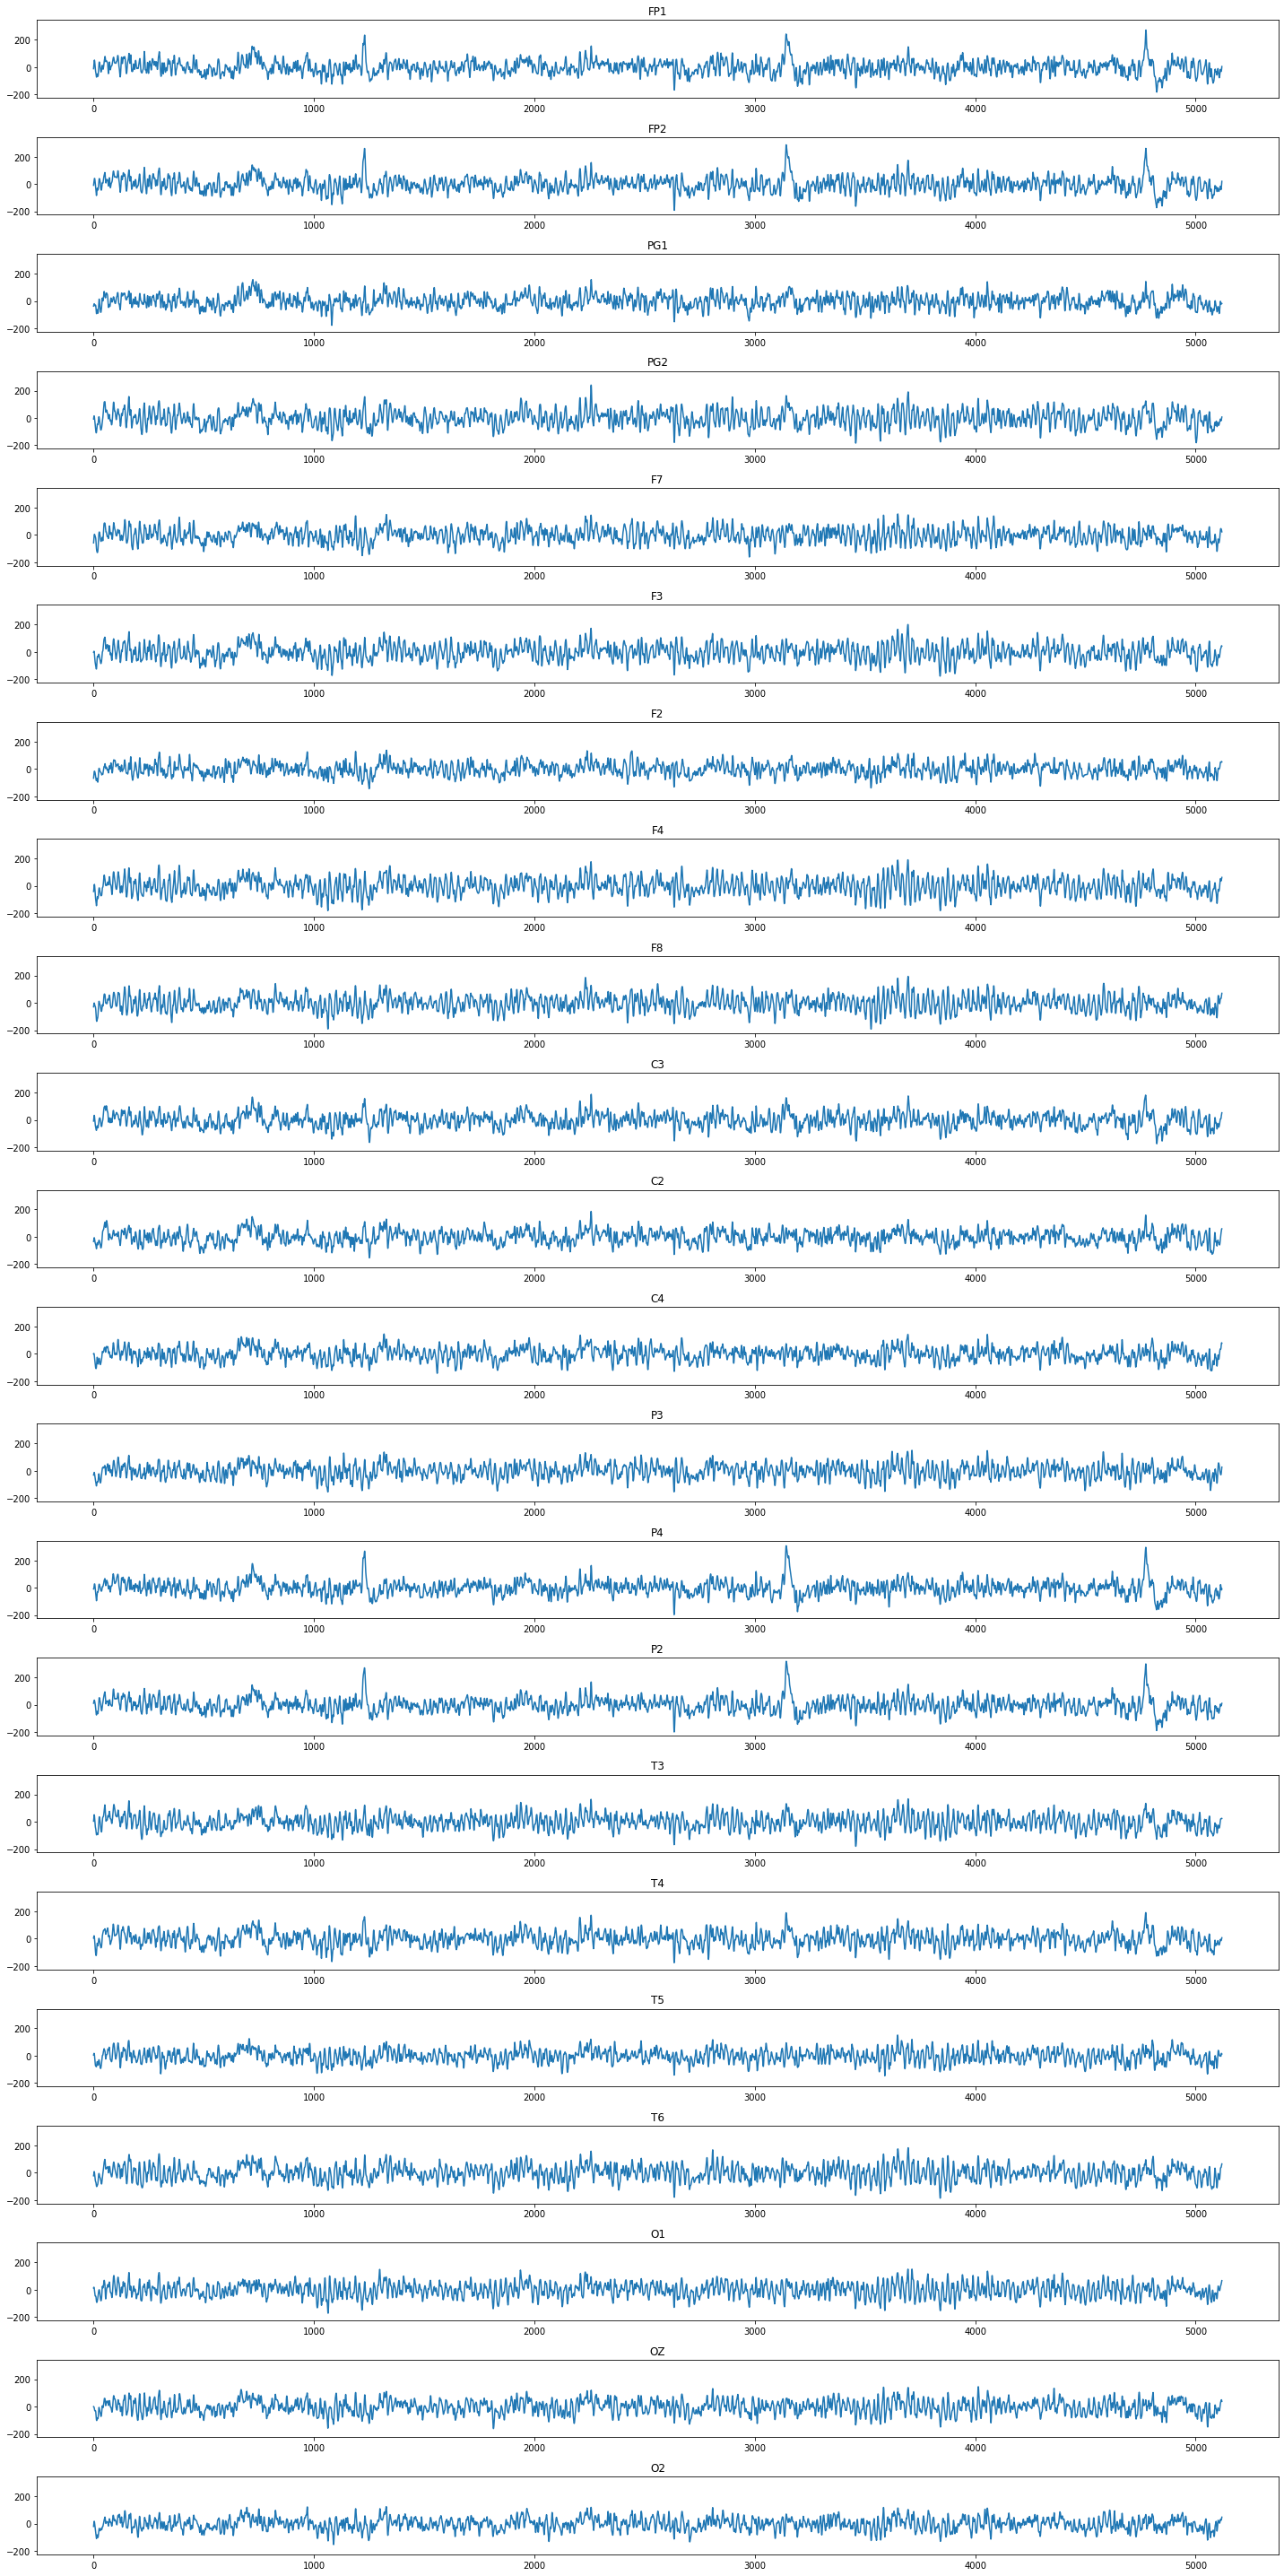

In [17]:
new_train = list(train.columns)
train.columns = new_train

fig, axes = plt.subplots(nrows=22, ncols=1, figsize=(20, 40), sharey = True)

for i, col in enumerate(train.columns):
  ax = axes[i]
  ax.plot(train[col])
  ax.set_title(col)

plt.tight_layout()
# plt.show
plt.savefig("pictures/EEG1.jpg")

In [33]:
class FeatureDataset(Dataset):
    def __init__(self, file_name):
        #read csv file and load row data into var
        file_out = pd.read_csv(file_name)
        x = file_out.iloc[1:23, 1:5120].values
        y = file_out.iloc[1:23, 5120:].values

        # feature scaling
        sc = StandardScaler()
        x_train = sc.fit_transform(x)
        y_train = y

        # converting to torch sensors 
        self.x_train = torch.tensor(x_train, dtype=torch.float32)
        self.y_train = torch.tensor(y_train)

    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index]

In [43]:
directory = '/Anne/Facultate/licenta/ScienceDirect_files_16Dec2022_10-38-19/CSV'
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        with open(os.path.join(directory, filename)) as f:
            file_name = os.path.join(directory, filename)
            # print (file_name)
#5120 DATA POINTS - 20s duration of 7 photic stimulus and resting period of 10s in between stimuli freq
column_names = ["FP1", "FP2", "PG1", "PG2", "F7", "F3", "F2", "F4", "F8", "C3", "C2", "C4", "P3", "P4", "P2", "T3", "T4", "T5", "T6", "O1", "OZ", "O2", "ECG"]


In [ ]:
feature_set = FeatureDataset('D:\Anne\Facultate\licenta\ScienceDirect_files_16Dec2022_10-38-19\CSV\sig1Hz_V1_B.csv')

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(4608, 128)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = nn.functional.sigmoid(x)
        return x

In [38]:
import torch.optim as optim
# split the data into features and labels
data_frames = [pd.read_csv(file_path, usecols=column_names) for file_path in file_name]
data = pd.concat(data_frames, ignore_index=True)
X = data.drop('label', axis=1)
y = data['label']

# reshape the features to a 4D tensor
X = torch.tensor(np.array(X).reshape(len(data_frames), 1, -1, len(column_names) - 1), dtype=torch.float32)
y = torch.tensor(np.array(y), dtype=torch.float32)
# create an instance of the CNN
net = Net()

# define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

# train the network
for epoch in range(10):
    running_loss = 0.0
    for i in range(len(x)):
        inputs = x[i]
        labels = y[i]
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch: %d, Loss: %.3f" % (epoch+1, running_loss/len(x)))

PermissionError: [Errno 13] Permission denied: '/'